In [1]:
import numpy as np
from astropy import units
import pyccl as ccl
import sacc

from matplotlib import pyplot as plt

In [2]:
cosmo = ccl.Cosmology(Omega_c=0.25,
                      Omega_b=0.05,
                      h=0.7,
                      n_s=0.965,
                      A_s=2.11e-9,
                      Omega_k=0.0,
                      Neff=3.046,
                      matter_power_spectrum='linear')

In [3]:
def setup_galaxy_tracers(cosmo, dndz, b1, s1):
    
    tracer_list = []
    
    for ibin in np.arange(1,dndz.shape[-1]):
        
        tracer_list.append(ccl.NumberCountsTracer(cosmo,
                                                  has_rsd=False,
                                                  dndz=(dndz[:,0], dndz[:,ibin-1]),
                                                  bias=(dndz[:,0], b1[ibin-1] * np.ones(len(dndz[:,0]))), 
                                                  mag_bias=(dndz[:,0], s1[ibin-1] * np.ones(len(dndz[:,0])))
                                                  )
                      )
    
    return tracer_list

In [4]:
def calculate_cl(cosmo, galaxy_tracers, cmb_tracer, dndz, ngal, binning):
   
    n_maps = len(galaxy_tracers) + 1
    
    cls = np.zeros([n_maps, n_maps, binning['n_ell']])

    cls[0, 0, :] = ccl.angular_cl(cosmo, cmb_tracer, cmb_tracer, binning['ells']) + Nell_act_k_binned

    for ibin in np.arange(1,dndz.shape[-1]):

        Nell_gals_bin = np.ones(binning['n_ell']) / (ngal[ibin-1].value * (60 * 180 / np.pi)**2)

        cls[0, ibin, :] = ccl.angular_cl(cosmo, galaxy_tracers[ibin-1], cmb_tracer, binning['ells'])
        cls[ibin, 0, :] = cls[0, ibin, :]

        for jbin in np.arange(1,dndz.shape[-1]):
            if ibin==jbin:
                cls[ibin, ibin, :] = ccl.angular_cl(cosmo, galaxy_tracers[ibin-1], galaxy_tracers[ibin-1], binning['ells']) + Nell_gals_bin
            else:
                cls[ibin, jbin, :] = ccl.angular_cl(cosmo, galaxy_tracers[ibin-1], galaxy_tracers[jbin-1], binning['ells'])
                cls[jbin, ibin, :] = ccl.angular_cl(cosmo, galaxy_tracers[jbin-1], galaxy_tracers[ibin-1], binning['ells'])
                
    return cls

In [5]:
def calculate_knox_covariance(cls, binning, fsky):
    
    n_maps = cls.shape[0]
    n_cross = (n_maps * (n_maps + 1)) // 2
    covar = np.zeros([n_cross, n_ell, n_cross, binning['n_ell']])

    id_i = 0
    for i1 in range(n_maps):
        for i2 in range(i1, n_maps):
            id_j = 0
            for j1 in range(n_maps):
                for j2 in range(j1, n_maps):
                    cl_i1j1 = cls[i1, j1, :]
                    cl_i1j2 = cls[i1, j2, :]
                    cl_i2j1 = cls[i2, j1, :]
                    cl_i2j2 = cls[i2, j2, :]
                    # Knox formula
                    cov = (cl_i1j1 * cl_i2j2 + cl_i1j2 * cl_i2j1) / (binning['delta_ell'] * fsky * (2 * binning['ells'] + 1))
                    covar[id_i, :, id_j, :] = np.diag(cov)
                    id_j += 1
            id_i += 1

    covar = covar.reshape([n_cross * n_ell, n_cross * n_ell])
    
    return covar

# Set up binning

In [6]:
ell_min = 100
ell_max = 1000
n_ell = 20
delta_ell = (ell_max - ell_min) // n_ell

ells = ell_min + (np.arange(n_ell) + 0.5) * delta_ell

ells_win = np.arange(ell_min, ell_max + 1)
wins = np.zeros([n_ell, len(ells_win)])

for i in range(n_ell):
    wins[i, i * delta_ell : (i + 1) * delta_ell] = 1.0
    
Well = sacc.BandpowerWindow(ells_win, wins.T)

binning = {'ell_max': ell_max,
           'n_ell': n_ell,
           'delta_ell': delta_ell,
           'ells': ells}

# Set up $dndz$

## DECALS

In [7]:
dndz_decals = np.loadtxt('./data/nzs_DECALS.txt')

Asky_decals = 17739 * units.deg * units.deg
fsky_decals = Asky_decals.value / 41253

Ngal_decals = np.array([14363105, 11554242, 13468310, 7232579]) / Asky_decals
ngal_decals = Ngal_decals.to(1 / (units.arcmin * units.arcmin))
ngal_decals_total = [ngal_decals.value.sum()] / (units.arcmin * units.arcmin)

b1_decals = [1.25, 1.56, 1.53, 1.83]
b2_decals = [1.26, 1.88, 1.84, 2.19]
b1_decals_total = [1.43]

s1_decals = [0.19, 0.29, 0.41, 0.57]
s1_decals_total = [np.mean(s1_decals)]

dndz_decals_total = np.column_stack([dndz_decals[:,0], np.einsum('i,...i', ngal_decals, dndz_decals[:,1:]).value])

print(ngal_decals)
print(ngal_decals_total)

[0.22491411 0.18092968 0.21090237 0.11325609] 1 / arcmin2
[0.73000225] 1 / arcmin2


## CMASS

In [8]:
dndz_cmass = np.loadtxt('./data/nz_sdss-cmass.txt')

dndz_cmass[:,1] /= -np.trapz(dndz_cmass[:,0], dndz_cmass[:,1])

Ngal_cmass = np.array([101.5]) / (units.deg * units.deg)
ngal_cmass = Ngal_cmass.to(1 / (units.arcmin * units.arcmin))

b1_cmass = [2.]
s1_cmass = [0.4] # i.e. no mag bias

print(ngal_cmass)

[0.02819444] 1 / arcmin2


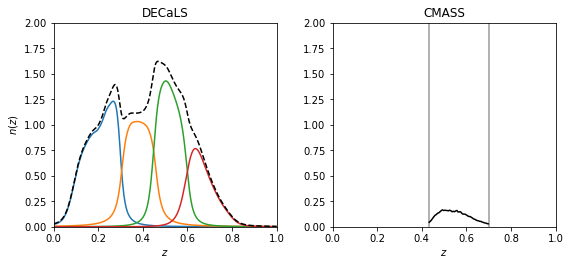

In [9]:
plt.figure(1, figsize=(2*4.5, 3.75))
plt.subplot(121)
for ibin in np.arange(1,dndz_decals.shape[-1]):
    plt.plot(dndz_decals[:,0], dndz_decals[:,ibin] * ngal_decals[ibin-1].value)
plt.plot(dndz_decals_total[:,0], dndz_decals_total[:,1], 'k--')
plt.xlabel('$z$')
plt.ylabel('$n(z)$')
plt.title('DECaLS')
plt.ylim([0,2.0])
plt.xlim([0,1.0])
plt.subplot(122)
plt.plot(dndz_cmass[:,0], dndz_cmass[:,1] * ngal_cmass[0].value, 'k-')
plt.axvline(0.43, color='k', alpha=0.4)
plt.axvline(0.7, color='k', alpha=0.4)
plt.xlabel('$z$')
plt.title('CMASS')
plt.ylim([0,2.])
plt.xlim([0,1.0])
plt.subplots_adjust(wspace=0.25)
plt.savefig('plots/decals-vs-cmass_nz.png', dpi=300, bbox_inches='tight');

# Set up ACT CMB lensing tracer

In [10]:
zstar = 1086
fsky_act = 0.051

tracer_act_k = ccl.CMBLensingTracer(cosmo, z_source=zstar)

# Approximation to SO LAT beam
fwhm_act_k = 2. * units.arcmin
sigma_act_k = (fwhm_act_k.to(units.rad).value / 2.355)
ell_beam = np.arange(3000)
beam_act_k = np.exp(-ell_beam * (ell_beam + 1) * sigma_act_k**2)

ell_planckNell, Nell_planck_k, _ = np.loadtxt('./data/nlkk.dat', unpack=True)
ell_actNellBN, Nell_actBN_k = np.loadtxt('./data/nlkk_actDR4only_BN.dat', unpack=True, delimiter=',')
ell_actNell, Nell_act_k = np.loadtxt('./data/nlkk_actDR4only_D56.dat', unpack=True, delimiter=',')

# Bin Nells to the same as data
bindx = np.digitize(ell_actNell, ells, right=True)
Nell_act_k_binned = [np.mean(Nell_act_k[bindx == i]) for i in range(0, len(ells))]

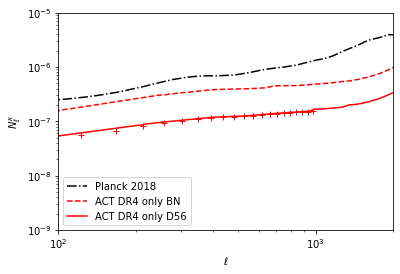

In [11]:
plt.close('all')
plt.loglog(ell_planckNell, Nell_planck_k, 'k-.', label='Planck 2018')
plt.loglog(ell_actNellBN, Nell_actBN_k, 'r--', label='ACT DR4 only BN')
plt.loglog(ell_actNell, Nell_act_k, 'r-', label='ACT DR4 only D56')
plt.loglog(ells, Nell_act_k_binned, 'r+')
plt.xlim([1e2, 2e3])
plt.ylim([1e-9,1e-5])
plt.legend(loc='lower left')
plt.xlabel('$\ell$')
plt.ylabel('$N_\ell^{\kappa}$');

# Set up galaxy tracers

In [12]:
cmass_tracer = setup_galaxy_tracers(cosmo, dndz_cmass, b1_cmass, s1_cmass)

In [13]:
decals_total_tracer = setup_galaxy_tracers(cosmo, dndz_decals_total, b1_decals_total, s1_decals_total)

In [14]:
decals_tracers = setup_galaxy_tracers(cosmo, dndz_decals, b1_decals, s1_decals)

# Calculate power spectra

In [15]:
cmass_cls = calculate_cl(cosmo, cmass_tracer, tracer_act_k, dndz_cmass, ngal_cmass, binning)

In [16]:
decals_total_cls = calculate_cl(cosmo, decals_total_tracer, tracer_act_k, dndz_decals_total, ngal_decals_total, binning)

In [17]:
decals_cls = calculate_cl(cosmo, decals_tracers, tracer_act_k, dndz_decals, ngal_decals, binning)

# Calculate covariance

In [18]:
cmass_cov = calculate_knox_covariance(cmass_cls, binning, fsky_act)

In [19]:
decals_total_cov = calculate_knox_covariance(decals_total_cls, binning, fsky_act)

In [20]:
decals_cov = calculate_knox_covariance(decals_cls, binning, fsky_act)

# Save the sacc files

In [21]:
s = sacc.Sacc()

s.add_tracer('NZ', 'gc_decals_total',
            quantity='galaxy_density',
            spin=0,
            z=dndz_decals_total[:,0],
            nz=dndz_decals_total,
            metadata={'ngal': np.sum(ngal_decals_total)})

s.add_tracer('Map', 'ck_act',
            quantity='cmb_convergence',
            spin=0,
            ell=ell_beam,
            beam=beam_act_k)

s.add_ell_cl('cl_00',
             'gc_decals_total',
             'gc_decals_total',
             ells, decals_total_cls[0, 0, :],
             window=Well)

s.add_ell_cl('cl_00',
             'gc_decals_total',
             'ck_act',
             ells, decals_total_cls[0, 1, :],
             window=Well)

s.add_ell_cl('cl_00',
             'ck_act',
             'ck_act',
             ells, decals_total_cls[1, 1, :],
             window=Well)

s.add_covariance(decals_total_cov)

s.save_fits('./data/decals_total_g-act_kappa.sim.sacc.fits', overwrite=True)

In [22]:
s = sacc.Sacc()

for ibin in np.arange(1,dndz_decals.shape[-1]):

    s.add_tracer('NZ', 'gc_decals_bin{}'.format(ibin),
                quantity='galaxy_density',
                spin=0,
                z=dndz_decals[:,0],
                nz=dndz_decals[:,ibin],
                metadata={'ngal': ngal_decals[ibin-1]})

    
s.add_tracer('Map', 'ck_act',
            quantity='cmb_convergence',
            spin=0,
            ell=ell_beam,
            beam=beam_act_k)

for ibin in np.arange(1,dndz_decals.shape[-1]):
    for jbin in np.arange(1,dndz_decals.shape[-1]):
        if ibin<=jbin:
            s.add_ell_cl('cl_00',
                         'gc_decals_bin{}'.format(ibin),
                         'gc_decals_bin{}'.format(jbin),
                         ells, decals_cls[ibin, jbin, :],
                         window=Well)

    s.add_ell_cl('cl_00',
                 'gc_decals_bin{}'.format(ibin),
                 'ck_act',
                 ells, decals_cls[0, ibin, :],
                 window=Well)

s.add_ell_cl('cl_00',
             'ck_act',
             'ck_act',
             ells, decals_cls[0, 0, :],
             window=Well)

s.add_covariance(decals_cov)

s.save_fits('./data/decals_g-act_kappa.sim.sacc.fits', overwrite=True)

In [23]:
s = sacc.Sacc()

s.add_tracer('NZ', 'gc_cmass',
            quantity='galaxy_density',
            spin=0,
            z=dndz_cmass[:,0],
            nz=dndz_cmass,
            metadata={'ngal': np.sum(ngal_cmass)})

s.add_tracer('Map', 'ck_act',
            quantity='cmb_convergence',
            spin=0,
            ell=ell_beam,
            beam=beam_act_k)

s.add_ell_cl('cl_00',
             'gc_cmass',
             'gc_cmass',
             ells, cmass_cls[1, 1, :],
             window=Well)

s.add_ell_cl('cl_00',
             'gc_cmass',
             'ck_act',
             ells, cmass_cls[0, 1, :],
             window=Well)

s.add_ell_cl('cl_00',
             'ck_act',
             'ck_act',
             ells, cmass_cls[0, 0, :],
             window=Well)

s.add_covariance(cmass_cov)

s.save_fits('./data/cmass_g-act_kappa.sim.sacc.fits', overwrite=True)

# Plot the spectra

In [24]:
s_decals = sacc.Sacc.load_fits('./data/decals_g-act_kappa.sim.sacc.fits')
s_decals_total = sacc.Sacc.load_fits('./data/decals_total_g-act_kappa.sim.sacc.fits')
s_cmass = sacc.Sacc.load_fits('./data/cmass_g-act_kappa.sim.sacc.fits')

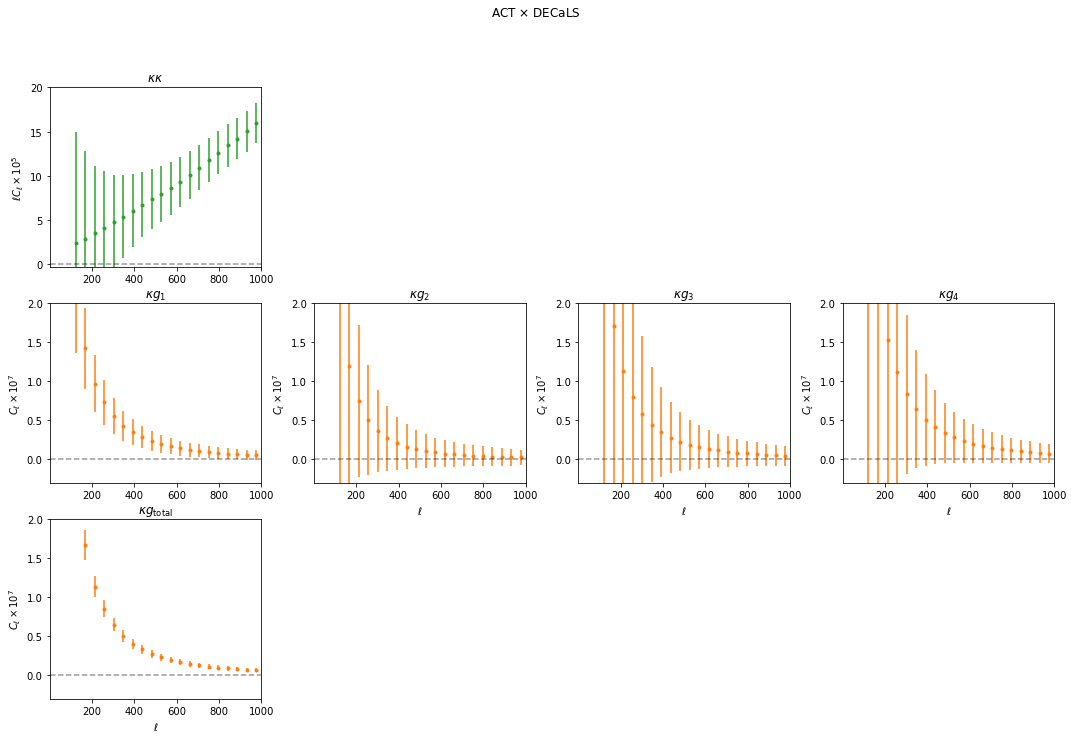

In [25]:
plt.close(1)
plt.figure(1, figsize=(4.*4.5, 3*3.75))

plt.suptitle(r'ACT $\times$ DECaLS')

plt.subplot(341)
plt.title(r'$\kappa\kappa$')
ell, cl, cov = s_decals.get_ell_cl('cl_00', 'ck_act', 'ck_act', return_cov=True)
cl_err = np.sqrt(np.diag(cov))
#plt.plot(ell_theory, 1.e5*ell_theory*cl_kk_theory , '--', c='C2')
plt.plot(ell, 1.e5*ell*cl, 'o', ms=3, c='C2')
plt.errorbar(ell, 1.e5*ell*cl, yerr=1.e5*ell*cl_err, fmt='none', c='C2')
plt.xlim([1,ell_max])
# plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell C_\ell \times 10^5$')
plt.ylim([-0.3, 20])
plt.axhline(0, color='k', linestyle='dashed', alpha=0.4)
plt.subplots_adjust(wspace=0.25);

for ibin in np.arange(1,dndz_decals.shape[-1]):
    plt.subplot(3,4,4+ibin)
    plt.title(r'$\kappa g_{}$'.format(ibin))
    ell, cl, cov = s_decals.get_ell_cl('cl_00', 'gc_decals_bin{}'.format(ibin), 'ck_act', return_cov=True)
    cl_err = np.sqrt(np.diag(cov))
    # plt.plot(ell_theory, 1.e5*ell_theory*cl_gk_theory , '--', c='C1')
    plt.plot(ell, 1.e7*cl, 'o', ms=3, c='C1')
    plt.errorbar(ell, 1.e7*cl, yerr=1.e7*cl_err, fmt='none', c='C1')
    plt.xlim([1,ell_max])
    if ibin>1:
        plt.xlabel(r'$\ell$')
    plt.ylabel(r'$C_\ell \times 10^7$')
    plt.axhline(0, color='k', linestyle='dashed', alpha=0.4)
    plt.ylim([-0.3, 2])

plt.subplot(349)
plt.title(r'$\kappa g_{\rm total}$')
ell, cl, cov = s_decals_total.get_ell_cl('cl_00', 'gc_decals_total', 'ck_act', return_cov=True)
cl_err = np.sqrt(np.diag(cov))
# plt.plot(ell_theory, 1.e5*ell_theory*cl_gk_theory , '--', c='C1')
plt.plot(ell, 1.e7*cl, 'o', ms=3, c='C1')
plt.errorbar(ell, 1.e7*cl, yerr=1.e7*cl_err, fmt='none', c='C1')
plt.xlim([1,ell_max])
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell \times 10^7$')
plt.axhline(0, color='k', linestyle='dashed', alpha=0.4)
plt.ylim([-0.3, 2])
plt.subplots_adjust(wspace=0.25)
plt.savefig('plots/decalsxact.png', dpi=300, bbox_inches='tight');

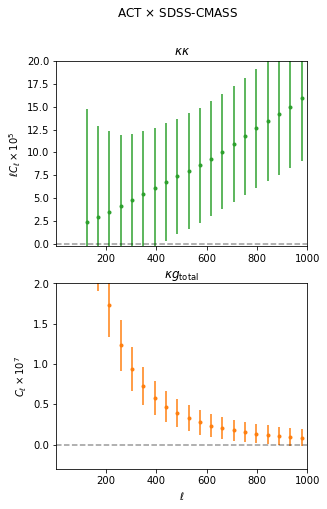

In [26]:
plt.close(1)
plt.figure(1, figsize=(4.5, 2*3.75))

plt.suptitle(r'ACT $\times$ SDSS-CMASS')

plt.subplot(211)
plt.title(r'$\kappa\kappa$')
ell, cl, cov = s_cmass.get_ell_cl('cl_00', 'ck_act', 'ck_act', return_cov=True)
cl_err = np.sqrt(np.diag(cov))
#plt.plot(ell_theory, 1.e5*ell_theory*cl_kk_theory , '--', c='C2')
plt.plot(ell, 1.e5*ell*cl, 'o', ms=3, c='C2')
plt.errorbar(ell, 1.e5*ell*cl, yerr=1.e5*ell*cl_err, fmt='none', c='C2')
plt.xlim([1,ell_max])
# plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell C_\ell \times 10^5$')
plt.ylim([-0.3, 20])
plt.axhline(0, color='k', linestyle='dashed', alpha=0.4)
plt.subplots_adjust(wspace=0.25);

plt.subplot(212)
plt.title(r'$\kappa g_{\rm total}$')
ell, cl, cov = s_cmass.get_ell_cl('cl_00', 'gc_cmass', 'ck_act', return_cov=True)
cl_err = np.sqrt(np.diag(cov))
# plt.plot(ell_theory, 1.e5*ell_theory*cl_gk_theory , '--', c='C1')
plt.plot(ell, 1.e7*cl, 'o', ms=3, c='C1')
plt.errorbar(ell, 1.e7*cl, yerr=1.e7*cl_err, fmt='none', c='C1')
plt.xlim([1,ell_max])
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell \times 10^7$')
plt.axhline(0, color='k', linestyle='dashed', alpha=0.4)
plt.ylim([-0.3, 2])
plt.subplots_adjust(wspace=0.25)
plt.savefig('plots/cmassxact.png', dpi=300, bbox_inches='tight');

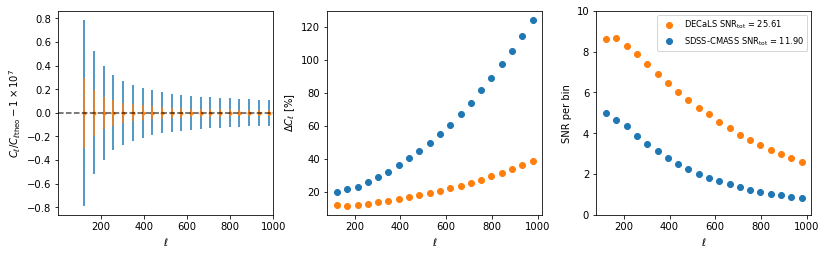

In [27]:
plt.close(1)
plt.figure(1, figsize=(3*4.5, 3.75))
plt.subplot(131)
ell, cl, cov = s_decals_total.get_ell_cl('cl_00', 'gc_decals_total', 'ck_act', return_cov=True)
cl_err = np.sqrt(np.diag(cov))
# plt.plot(ell_theory, 1.e5*ell_theory*cl_gk_theory , '--', c='C1')
plt.plot(ell, cl/cl - 1, 'o', ms=3, c='C1')
plt.errorbar(ell, cl/cl - 1, yerr=1e7*cl_err, fmt='none', c='C1')
plt.xlim([1,ell_max])
plt.xlabel(r'$\ell$')
plt.ylabel(r'$ C_\ell / C_{\ell \rm{theo}} - 1 \times 10^7$')
plt.axhline(0., color='k', linestyle='dashed', alpha=0.4)
plt.subplot(132)
plt.plot(ell, 100.*cl_err/cl, 'o', c='C1')
plt.ylabel(r'$ \Delta C_\ell$ [$\%$]')
plt.xlabel(r'$\ell$')
plt.subplot(133)
snr = np.sqrt(np.dot(cl.T, np.dot(np.linalg.inv(cov), cl)))
plt.plot(ell, cl/cl_err, 'o', c='C1', label='DECaLS SNR$_{\\rm tot}$'+' = {:.2f}'.format(snr))
plt.ylabel(r'SNR')
plt.xlabel(r'$\ell$')
# plt.text(200, 6.5, 'DECALS SNR$_{\\rm tot}$'+' = {:.2f}'.format(np.sqrt(np.sum((cl/cl_err)**2.))));
#plt.yscale('log')
#plt.ylim([-0.3, 2]);

plt.subplot(131)
ell, cl, cov = s_cmass.get_ell_cl('cl_00', 'gc_cmass', 'ck_act', return_cov=True)
cl_err = np.sqrt(np.diag(cov))
# plt.plot(ell_theory, 1.e5*ell_theory*cl_gk_theory , '--', c='C1')
# plt.plot(ell, cl/cl - 1, 'o', ms=3, c='C1')
plt.errorbar(ell, cl/cl - 1, yerr=1e7*cl_err, fmt='none', c='C0', zorder=-1)
plt.xlim([1,ell_max])
plt.xlabel(r'$\ell$')
plt.ylabel(r'$ C_\ell / C_{\ell \rm{theo}} - 1 \times 10^7$')
plt.axhline(0., color='k', linestyle='dashed', alpha=0.4)
plt.subplot(132)
plt.plot(ell, 100.*cl_err/cl, 'o', c='C0')
plt.ylabel(r'$ \Delta C_\ell$ [$\%$]');
plt.subplot(133)
snr = np.sqrt(np.dot(cl.T, np.dot(np.linalg.inv(cov), cl)))
plt.plot(ell, cl/cl_err, 'o', c='C0', label='SDSS-CMASS SNR$_{\\rm tot}$'+' = {:.2f}'.format(snr))
plt.ylabel(r'SNR per bin')
plt.ylim([0,10])
plt.legend(loc='upper right', fontsize='small')
plt.subplots_adjust(wspace=0.25)
plt.savefig('plots/decalsxact-vs-cmassxact.png', dpi=300, bbox_inches='tight');
# plt.text(200, 8, 'SDSS-CMASS SNR$_{\\rm tot}$'+' = {:.2f}'.format(np.sqrt(np.sum((cl/cl_err)**2.))));
#plt.yscale('log')
#plt.ylim([-0.3, 2])